<a href="https://colab.research.google.com/github/MinsooKwak/image_caption/blob/main/image_caption_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

이미지 처리를 위해서는 CNN 계열의 모델, 자연어 처리를 위해서는 RNN계열의 모델을 활용해 이미지를 캡션할 수 있다. 

최근 Transformer 기반의 모델들이 대두되고 SOTA를 기록하고 있는 것을 볼 수 있다. 

CNN 계열의 backbone을 고민하기에 앞서 이미지 처리에도 transformer를 활용한 ViT, SwinTransformer가 SOTA를 기록하고 있다. 

ViT가 이미지를 작은 patch들로 쪼개면서 많은 computational complexity를 기록함에 있어 SwinTrnaformer가 shifted window partitioning을 통해 window 내부에서만 patch들끼리 self-attention을 통해 ViT의 문제를 해결했지만, SwinTransformer의 경우 2021년 등장한 비교적 최신 모델이기 때문에 해당 프로젝트를 진행하기에는 추가적인 노력이 필요하다 생각되었다. 

이에 이전에 많이 사용된 ResNet 또는 Inception을 활용하는 것이 적합하다 생각되어 진행하고자 한다.

# Image Captioning Project

In [1]:
# 경고를 무시합니다.
import warnings
warnings.filterwarnings("ignore")

## Import Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
root_directory = '/content/drive/MyDrive/ImageCaption/Data/flickr8k'

In [5]:
df = pd.read_csv('/content/drive/MyDrive/ImageCaption/Data/flickr8k/captions.txt')
df

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [6]:
df2 = pd.DataFrame(df.image.value_counts())
df2 = df2.reset_index()
df2

,index,image
0,1000268201_693b08cb0e.jpg,5
1,3388094307_5a83be64a5.jpg,5
2,3393394134_0caac47e1c.jpg,5
3,3393343330_b13df4d8ec.jpg,5
4,3393152604_27bd1037f2.jpg,5
...,...,...
8086,2699733386_c346c87ea6.jpg,5
8087,2699426519_228719b1db.jpg,5
8088,2699342860_5288e203ea.jpg,5
8089,2699125097_c6801d80ed.jpg,5


In [7]:
df2.image.value_counts()

5    8091
Name: image, dtype: int64

- 모든 이미지는 5개의 caption을 갖고 있음

# Preprocess

- 아래 불용어 처리 단계에서 발견한 전처리가 필요한 단어 처리를 진행

In [8]:
df.head(3)

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .


In [9]:
def word_prep(str):
  str = str.replace('coca','')
  str = str.replace('cola','coca-cola')
  str = str.replace('hapily','happily')
  str = str.replace('playy','play')
  str = str.replace('fronmt','front')
  str = str.replace('litle','little')
  str = str.replace('offf','off')
  str = str.replace('giong','going')
  str = str.replace('rakes','lakes')
  str = str.replace('sidwalk','sidewalk')
  str = str.replace('mommy','mom')
  str = str.replace('woamn','woman')
  str = str.replace('feamle','female')
  str = str.replace('matchin','matching')
  str = str.replace('jello','hello')
  str = str.replace('silohuetted','silhouetted')
  str = str.replace('redhead','red head')
  str = str.replace('ypoung','young')
  str = str.replace('unner','under')
  return str

In [10]:
df['caption'] = df['caption'].apply(word_prep)

In [11]:
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


## Tokeninzing

**영어 토큰화**

  > 특정한 구두점 문자를 대체하고 나머지 공백 문자를 기반으로 분할을 진행하는 keras tokenizer의 특성을 고려해 keras를 통한 토큰화 진행하기로 결정

- NLTK
  - 정규화 기반 (속도 빠름)
- spacy
  - 처리 속도는 NLTK, Keras 대비 낮으나 다른 성능 측면에서 우수
- **keras**
  - 정규화 기반 (속도 빠름)
  - 모든 토큰을 소문자로 변경
  - Don't를 don't로 Jone's를 jone's로 변경 
  - 마침표나 쉼표 등의 구두점은 버림

참고 : 
- https://mollymollang.tistory.com/18
- https://na0-0.tistory.com/67


전처리 패키지 (추가 참고) : https://datascienceschool.net/03%20machine%20learning/01.02%20%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%EC%9A%A9%20%ED%8C%8C%EC%9D%B4%EC%8D%AC%20%ED%8C%A8%ED%82%A4%EC%A7%80.html

In [12]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

def token_word(string):
  '''
  token화 후 토큰들을 list로 return하는 함수 정의
  '''
  str_list = text_to_word_sequence(string)
  return str_list

In [13]:
df['token'] = df.caption.apply(token_word)
df['len'] = df.caption.apply(lambda x : len(x))
df.head()

,image,caption,token,len
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,"[a, child, in, a, pink, dress, is, climbing, u...",72
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,"[a, girl, going, into, a, wooden, building]",37
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,"[a, little, girl, climbing, into, a, wooden, p...",48
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,"[a, little, girl, climbing, the, stairs, to, h...",52
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,"[a, little, girl, in, a, pink, dress, going, i...",57


In [14]:
df.describe()

,len
count,40455.000000
mean,55.138154
std,18.841860
min,1.000000
25%,41.500000
50%,53.000000
75%,66.000000
max,199.000000


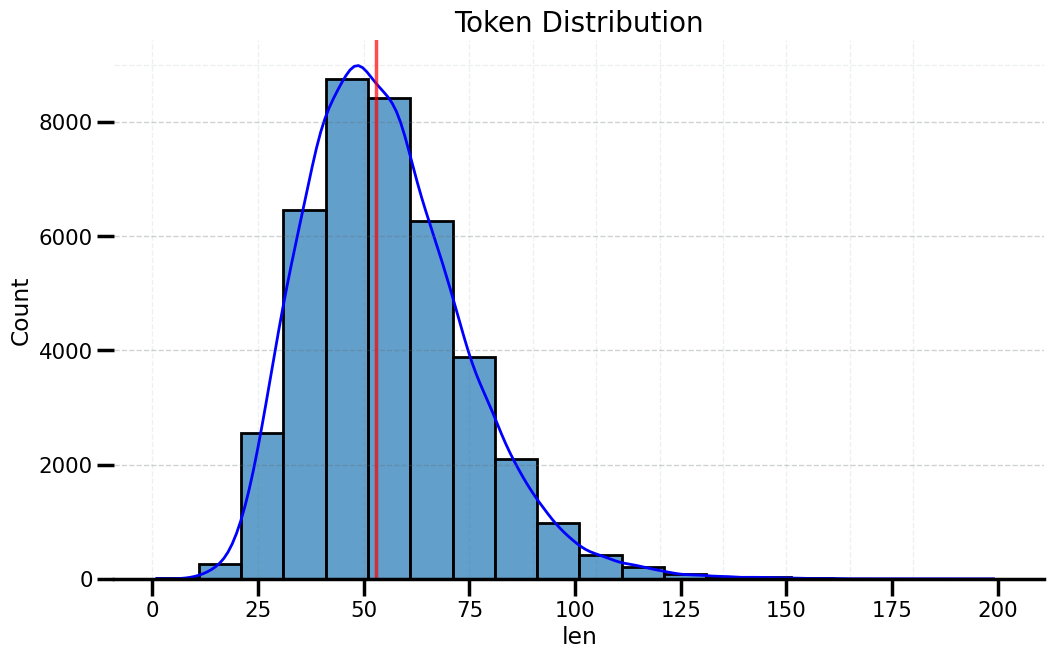

In [15]:
#sns.set_style('white',{'font.family':'NanumSquare'})
sns.set_context("poster", font_scale = 0.7, rc={"grid.linewidth": 5})

fig1, axes = plt.subplots(1,1, figsize=(12,7))
fig1.gca().spines['right'].set_visible(False)   # 오른쪽 테두리 제거
fig1.gca().spines['top'].set_visible(False)     # 위 테두리 제거
fig1.gca().spines['left'].set_visible(False)    # 왼쪽 테두리 제거

ax1 = sns.histplot(df, x='len', binwidth=10, alpha=0.7, kde=True,
                   line_kws={'lw':2} 
                   ## 'color':'b' 적용이 안되서 대안으로 아래 방식 활용
                   )
ax1.lines[0].set_color('b')
  
# 값의 폭을 10단위로 확인해봄 # bins=n 통해 bin 개수 조절 가능
ax1.set_title('Token Distribution', fontsize=20)

# y축 설정
plt.axhline(y=2000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)
plt.axhline(y=4000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)
plt.axhline(y=6000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)
plt.axhline(y=8000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)
plt.axhline(y=9000, color='#626774', linestyle='--', linewidth=1, alpha=0.1)

# x 축 설정
plt.axvline(x=0, color='#626774', linestyle='--', linewidth=1, alpha=0.1)
plt.axvline(x=25, color='#626774', linestyle='--', linewidth=1, alpha=0.1)
plt.axvline(x=50, color='#626774', linestyle='--', linewidth=1, alpha=0.1)
plt.axvline(x=75, color='#626774', linestyle='--', linewidth=1, alpha=0.1)
plt.axvline(x=90, color='#626774', linestyle='--', linewidth=1, alpha=0.1)
plt.axvline(x=105, color='#626774', linestyle='--', linewidth=1, alpha=0.1)
plt.axvline(x=120, color='#626774', linestyle='--', linewidth=1, alpha=0.1)
plt.axvline(x=135, color='#626774', linestyle='--', linewidth=1, alpha=0.1)
plt.axvline(x=150, color='#626774', linestyle='--', linewidth=1, alpha=0.1)
plt.axvline(x=165, color='#626774', linestyle='--', linewidth=1, alpha=0.1)
plt.axvline(x=180, color='#626774', linestyle='--', linewidth=1, alpha=0.1)

# 중위수 표시
plt.axvline(x=df['len'].median(), color='r', linestyle='-', linewidth=2.5, alpha=0.7)

- 추가적으로 확인 가능 요소 
> 추후 성능 확인 진행 후 token len과 성능 비교   

  - 유의미한지 
  - 영향이 있는지 상관분석

## Dictionary 생성 및 불용어 제외

**Dictionary 생성 및 token 개수 파악**

> Counter 생성자를 통해 중복된 데이터가 저장된 배열에서 각 원소가 몇 번씩 저장되었는지 저장된 객체를 얻어오겠다. 

In [16]:
# Counter 통해 중복된 데이터가 저장된 배열에서 각 원소가 몇 번씩 저장되었는지 확인
from collections import Counter

In [17]:
df.head(3)

,image,caption,token,len
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,"[a, child, in, a, pink, dress, is, climbing, u...",72
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,"[a, girl, going, into, a, wooden, building]",37
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,"[a, little, girl, climbing, into, a, wooden, p...",48


**형태소 단위 빈도 분석**

In [18]:
combined_token_list = [i for tok_list in df['token'] for i in tok_list] # 하나의 리스트에 담음
print(len(combined_token_list))
# combined_token_list

437665


In [19]:
frequent = Counter(combined_token_list).most_common()
#print(f'unique한 token의 개수 : {len(words)}')
print(len(frequent))

8478


In [20]:
frequent[:5]

[('a', 62992), ('in', 18986), ('the', 18419), ('on', 10745), ('is', 9345)]

In [21]:
frequent_df = pd.DataFrame(frequent)
#frequent_df.sort_values(ascending=True)
frequent_df.head()

,0,1
0,a,62992
1,in,18986
2,the,18419
3,on,10745
4,is,9345


### remove stopwords

> **전처리 라이브러리** 
  - **OpenAI CLIP** : 
    - 이미지와 텍스트를 함께 입력 받아 벡터 변환
    - 불용어를 위한 텍스트 전처리 기능은 없음
    - 텍스트 데이터를 직접 조작할 수 있는 API 제공
    - 원하는 전처리 수행 가능
  - **NLP**:
    - NLTK, SpaCy, Gensim ...
  - **Custom Preprocessing**
    - 이미지와 텍스트 간 연관성 고려해 텍스트 처리 함수를 작성하고, 해당 함수를 활용에 불용어 제거 및 타 전처리 작업 수행 가능


- 해당 방식 중 **NLP 방식** 활용할 것

  - 불용어는 영향력이 없기 때문에 텍스트 처리를 진행하고 추후 모델을 통해 이미지와 텍스트의 관계성을 고려하려한다.
  > 활용 가능 라이브러리 : NLTK, SpaCy, Gensim ...
    - **Tensorflow + NLTK**
    - Tensorflow + SpaCy
    - **PyTorch + NLTK**
    - PyTorch + Gensim : 주로 토픽모델링, 단어 임베딩
  
  대표적인 NLTK를 활용하도록 하겠다.

In [22]:
import nltk
from nltk.corpus import stopwords

# 불용어 다운
nltk.download('stopwords')

# 불용어 집합에 담음
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [23]:
# NLTK 활용해 불용어 제거
# filtered_text = [w fo w in tokenized_text if w not in stop_words]

# 일단 2가지 처리 방식
## 1) 모델링에 stopword 처리된 것 활용 가능 -> filtered_token feature 생성
## 2) 위 불용어 집합 통해 리스트에서 불용어 처리

In [24]:
remove_stopwords = [x for x in combined_token_list if x not in stop_words]
frequent2 = Counter(remove_stopwords).most_common()
print(len(frequent2))

8360


In [25]:
frequent_df2 = pd.DataFrame(frequent2)
# 불용어 파악 위해 리스트 csv 저장
frequent_df2.to_csv('stopword_prepare.csv')

In [26]:
####### 보고 불용어 파악
## 숫자는 주요 정보일 수 있으므로 제거하지 않겠음
stopword2 = ['s',"'",'st','c','u','p','v','n','ac','ou',"n'",'gin','od','lav','kelp','nd','gren',
             'tbe','gith','dhe','h','la','osme','ot','djs','hte','fronr','ox','shire','hdr','rung',
             'boe','twp','vfw','ti','chi','tho','ont','mma','iove','ump','outise','lei','pf','ee',
             'thong','tge','ilks','r','floatlys','stucco','arc','brwon']

- 불용어 파악 단계에서 전처리 필요 단어들 발견
- 해당 내용은 토큰화 직전 부분에서 처리하는 것으로 순서 변경해 진행함
- 위 참조

In [27]:
def filter_tokens(string):
  string = [s for s in string if s not in stop_words]
  string = [s for s in string if s not in stopword2]
  return string

In [28]:
df['filtered_token']=df['token'].apply(filter_tokens)
df.head()

,image,caption,token,len,filtered_token
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,"[a, child, in, a, pink, dress, is, climbing, u...",72,"[child, pink, dress, climbing, set, stairs, en..."
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,"[a, girl, going, into, a, wooden, building]",37,"[girl, going, wooden, building]"
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,"[a, little, girl, climbing, into, a, wooden, p...",48,"[little, girl, climbing, wooden, playhouse]"
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,"[a, little, girl, climbing, the, stairs, to, h...",52,"[little, girl, climbing, stairs, playhouse]"
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,"[a, little, girl, in, a, pink, dress, going, i...",57,"[little, girl, pink, dress, going, wooden, cabin]"


In [29]:
df['filtered_len']=df['filtered_token'].apply(len)
df.head()

,image,caption,token,len,filtered_token,filtered_len
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,"[a, child, in, a, pink, dress, is, climbing, u...",72,"[child, pink, dress, climbing, set, stairs, en...",8
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,"[a, girl, going, into, a, wooden, building]",37,"[girl, going, wooden, building]",4
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,"[a, little, girl, climbing, into, a, wooden, p...",48,"[little, girl, climbing, wooden, playhouse]",5
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,"[a, little, girl, climbing, the, stairs, to, h...",52,"[little, girl, climbing, stairs, playhouse]",5
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,"[a, little, girl, in, a, pink, dress, going, i...",57,"[little, girl, pink, dress, going, wooden, cabin]",7


(0.0, 9500.0)

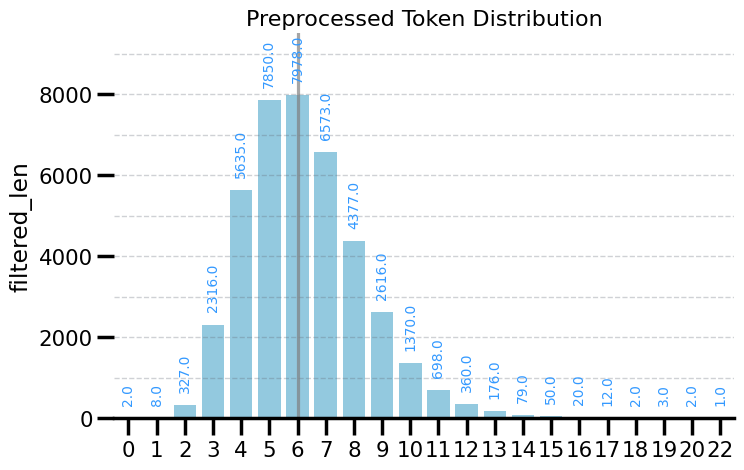

In [30]:
sns.set_context("poster", font_scale = 0.7, rc={"grid.linewidth": 5})

fig2, axes2 = plt.subplots(1,1, figsize=(8,5))
fig2.gca().spines['right'].set_visible(False)   # 오른쪽 테두리 제거
fig2.gca().spines['top'].set_visible(False)     # 위 테두리 제거
fig2.gca().spines['left'].set_visible(False)    # 왼쪽 테두리 제거

ax2 = sns.barplot(x=df['filtered_len'].value_counts().index, y=df['filtered_len'].value_counts(), color='skyblue')
  
# 값의 폭을 10단위로 확인해봄 # bins=n 통해 bin 개수 조절 가능
ax2.set_title('Preprocessed Token Distribution', fontsize=16)

# y축 설정
plt.axhline(y=1000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)
plt.axhline(y=2000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)
plt.axhline(y=3000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)
plt.axhline(y=4000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)
plt.axhline(y=5000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)
plt.axhline(y=6000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)
plt.axhline(y=7000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)
plt.axhline(y=8000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)
plt.axhline(y=9000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)

# 중위수 표시
plt.axvline(x=df['filtered_len'].median(), color='gray', linestyle='-', linewidth=2.3, alpha=0.7)

for p in ax2.patches:
  height = p.get_height()
  ax2.text(p.get_x() + p.get_width()/2., height+400, height, ha='center', color='#3399FF', fontsize=10, rotation=90)
ax2.set_ylim(0,9500)

### 빈도어

In [31]:
df.head(3)

,image,caption,token,len,filtered_token,filtered_len
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,"[a, child, in, a, pink, dress, is, climbing, u...",72,"[child, pink, dress, climbing, set, stairs, en...",8
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,"[a, girl, going, into, a, wooden, building]",37,"[girl, going, wooden, building]",4
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,"[a, little, girl, climbing, into, a, wooden, p...",48,"[little, girl, climbing, wooden, playhouse]",5


In [32]:
# 하나의 리스트에 담음
filtered_token_list = [i for tok_list in df['filtered_token'] for i in tok_list]

# Top15 단어
freq = Counter(filtered_token_list).most_common()
filtered_freq_df = pd.DataFrame(freq)
filtered_freq_df.head(15).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,dog,man,two,white,black,boy,woman,girl,wearing,people,water,red,young,brown,blue
1,8138,7274,5642,3959,3848,3581,3403,3328,3062,2883,2790,2714,2630,2578,2279


### Embedding 사전 만들기

- keras의 embedding()을 활용하여 처음부터 임베딩 벡터를 학습하는 방법이 있으나, 훈련 데이터가 적은 상황으로 최적화된 임베딩 값을 얻는 것에 한계가 있으므로, 사전 훈련된 glove를 활용해 embedding vector 값을 얻어오려한다.
- GloVe를 활용할 수 있도록 glove library를 활용하겠다.

> 1. **Word2Vec**
  - 장점 : 단어 유추 작업에 뛰어남
  - 한계 : window를 설정해 예측 -> 전체적 통계 정보 반영 어려움
    - cBow : 주변 단어로 중간 단어 예측 #sliding window
    - skip-gram : 중심 단어로 주변 단어 예측
      - cBow보다 성능 좋음
> 2. **LSA**
  - TF-IDF와 같이 각 문서에서의 단어 빈도수 카운트 행렬 기반 학습 모델
  - 차원을 축소하여 Latent Representation을 끌어냄
  - 단어 유추에서 좋지 않은 성능
> 3. **Glove (2014)**
  - Word2Vec, LSA의 한계를 혼합하여 장점 취함
  - Word2Vec과 함께 가장 많이 쓰임
  - 단어 간 동시 발생 빈도 비율이 벡터 공간 차이로 나타나도록 단어 임베딩을 수행함
> 4. **Fasttext (SOTA, 2016)**
  - Word2Vec 확장판
  - subword를 간주해 학습
  - 오타에 강건함, 빠름, 별도 전처리 필요 없음

In [ ]:
!pip install glove_python

In [ ]:
from glove import Corpus, Glove

corpus = Corpus() 

# 훈련 데이터로부터 GloVe에서 사용할 동시 등장 행렬 생성
corpus.fit(result, window=5)
glove = Glove(no_components=100, learning_rate=0.05)

# 학습에 이용할 쓰레드의 개수는 4로 설정, 에포크는 20.
glove.fit(corpus.matrix, epochs=20, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)

In [ ]:
print(glove.most_similar("man"))

살펴봐야할 내용 (스터디)

- https://wikidocs.net/182469
- https://velog.io/@fe26ming/%EB%94%A5%EB%9F%AC%EB%8B%9D-8%EC%9D%BC%EC%B0%A8
- https://han-py.tistory.com/271
- https://m.blog.naver.com/askif2/222024172658
- https://www.lucypark.kr/courses/2015-dm/text-mining.html


참조 : https://www.dinolabs.ai/295

DenseCap

https://tensorflow.blog/2016/04/21/densecap-fully-convolutional-localization-networks-for-dense-captioning/

github : https://github.com/jcjohnson/densecap